In [1]:
from google.colab import files
src = list(files.upload().values())

Saving basic_units.py to basic_units.py


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import Tuple, MutableSequence
import random
import math
from basic_units import radians
import pandas as pd


# Common settings

In [3]:
series_len = 5000
random.seed(0)

In [4]:
def get_rad_ticks(range_start: int = 0, range_stop: int = 2, step: int = 1) -> Tuple:
    # """Generate ticks and labels for them in given interval

    #   Parameters
    #   ----------
    #   range_start: int
    #     Left edge of the interval. Will be included in the range.
    #   range_stop: int
    #     Right edge of the interval. Won't be included in the range.
    #   step: int
    #      An integer number specifying the incrementation.

    #   Returns
    #   -------
    #   Tuple
    #     Tuple with two arrays: ticks and labels
    # """
    labels = []

    for i in range(range_start, range_stop, step):
        if i == 0:
            labels.append('0')
            continue
        if i == 1:
            labels.append('π')
            continue
        if i == -1:
            labels.append('-π')
            continue
        labels.append(str(i) + 'π')
    
    ticks = [i*math.pi for i in range(range_start, range_stop, step)]
    return ticks, labels

In [5]:
def noise(freq, series_len):
  # """Return single frequency noise

  #   Parameters
  #   ----------
  #   freq: int
  #     Noise frequency
  #   series_len: int
  #     Length of noise vector
  #
  #   Returns
  #   -------
  #   [float]
  #     The noise vector of a given frequency
  # """
  phase = random.uniform(0, 2*math.pi)
  return np.array([math.sin(2*math.pi * freq*x/series_len + phase) for x in range(series_len)])

In [6]:
def generate_noise(series_len = series_len, amplitude = lambda f: 1, frequencies = range(1, 1001), random_seed = 0, debugging = False):
  # """Generates noise of different spectrum

  #   Parameters
  #   ----------
  #   series_len: int
  #     Length of noise vector
  #   amplitude: Callable[[int], float]
  #     Should return amplitude depending on frequency. Return const 1 by default.
  #   frequencies: [int]
  #     Range of frequencies
  #   random_seed: int
  #     Value for random.seed()
  #   debugging: boolean
  #     Flag to activate debug mode
  #
  #   Returns
  #   -------
  #   [float]
  #     The noise vector of a given spectrum
  # """
  random.seed(random_seed)
  sum_of_noises = [0.0] * series_len
  amplitudes = np.array([amplitude(f) for f in frequencies])
  noises = np.array([noise(f, series_len) for f in frequencies])

  if debugging:
    print('amplitudes length = {}'.format(len(amplitudes)))
    print('noises length = {}'.format(len(noises)))

  for k in range(len(noises)):
    sum_of_noises += amplitudes[k] * noises[k]

  return sum_of_noises

In [7]:
def derivative_next_value(x_t: float, f_t: float = 0) -> float:
  # """Calculate value of x'(t+1) depending on x(t) and f(t)

  #   Parameters
  #   ----------
  #   x_t: float
  #     Value of the function in point t
  #   f_t: float
  #     Noise in point t

  #   Returns
  #   -------
  #   float
  #     Value of the derivative in point t+1
  # """
  return np.sin(x_t) + f_t


In [8]:
def function_next_value(x_t: float, delta: float = 0.1, f_t: float = 0) -> float:
  # """Calculate value of x(t+1) depending on x(t), f(t) and delta t

  #   Parameters
  #   ----------
  #   x_t: float
  #     Value of the function in point t
  #   delta: float
  #     Increment of the argument
  #   f_t: float
  #     Noise in point t

  #   Returns
  #   -------
  #   float
  #     Value of the function in point t+1
  # """
  d_t = derivative_next_value(x_t, f_t)
  return x_t + delta*d_t

In [9]:
def get_samples(series_len: int = series_len, x_t_init: float = 0, random_seed: int = 0, noise: MutableSequence[float] = None, delta: float = 0.1) -> Tuple:
    # """Calculate value of x(t+1) depending on x(t), f(t) and delta t

    #   Parameters
    #   ----------
    #   series_len: int
    #     Length of noise vector
    #   random_seed: int
    #     Value for random.seed()
    #   noise: MutableSequence[float]
    #     Noise vector
    #   delta: float
    #     Increment of the argument

    #   Returns
    #   -------
    #   Tuple
    #     Two vectors: function values in the time points and values of derivative of this function in the same points of time
    # """
    random.seed(random_seed)

    if noise is None:
        noise = [0 for _ in range(series_len)]

    x_t = x_t_init
    x_ts = []
    d_ts = []
    x_ts.append(x_t)
    d_ts.append(derivative_next_value(x_t))
    for t in range(1, series_len):
        x_t = function_next_value(x_t, delta, f_t=noise[t])
        d_t = derivative_next_value(x_t, f_t=noise[t])
        x_ts.append(x_t)
        d_ts.append(d_t)

    return x_ts, d_ts

In [10]:
def calc_time_between_transitions(samples: MutableSequence[float], delta_t: float = 0.1) -> MutableSequence[float]:
    # """Calculate delta t between transition point
    #
    #   Parameters
    #   ----------
    #   samples: MutableSequence[float]
    #     Function values
    #   delta_t: float
    #     Time increment
    #
    #   Returns
    #   -------
    #   MutableSequence[float]
    #     Array with values of time 
    # """
    time_gaps = []
    n_delta_t = 0
    previous_level = round(samples[0]/math.pi)
    for i in range(1, len(samples)):
        sample_level = round(samples[i]/math.pi)
        n_delta_t += 1

        if sample_level != previous_level:
            time_gaps.append(n_delta_t*delta_t)
            n_delta_t = 0
            previous_level = sample_level
    return time_gaps

In [11]:
def set_up_plot(title: str, figsize: Tuple = (12, 6), ticks_range: Tuple = (0, 2)):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
  fig.tight_layout(pad=5.)
  fig.suptitle(title, fontsize=16)

  ax1.set_yticks(*get_rad_ticks(*ticks_range))
  ax1.set_title('Dependence of the function on time')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Function in time point')

  ax2.set_xticks(*get_rad_ticks(*ticks_range))
  ax2.set_title('Dependence of the derivative on function')
  ax2.set_xlabel('Function in time point')
  ax2.set_ylabel('Derivative of function in time point')

  return ax1, ax2

# Without noise

## Graphs of the function and derivative

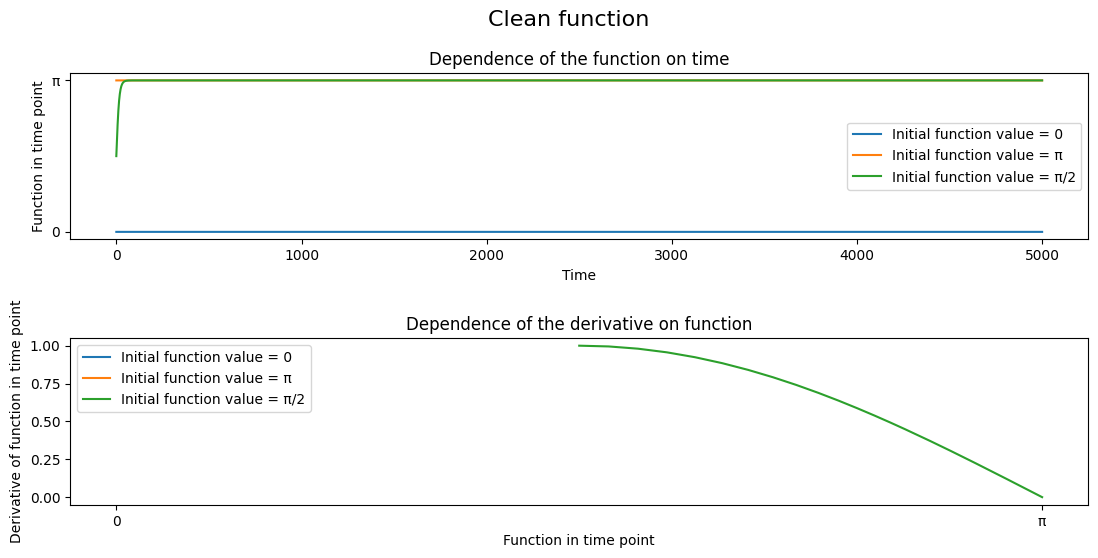

In [35]:
x_ts_0, d_ts_0 = get_samples(x_t_init = 0)
x_ts_pi, d_ts_pi = get_samples(x_t_init = math.pi)
x_ts_half_pi, d_ts_half_pi = get_samples(x_t_init = math.pi/2)

ax1, ax2 = set_up_plot('Clean function')

ax1.plot(x_ts_0, label='Initial function value = 0')
ax1.plot(x_ts_pi, label='Initial function value = π')
ax1.plot(x_ts_half_pi, label='Initial function value = π/2')
ax1.legend()

ax2.plot(x_ts_0, d_ts_0, label='Initial function value = 0')
ax2.plot(x_ts_pi, d_ts_pi, label='Initial function value = π')
ax2.plot(x_ts_half_pi, d_ts_half_pi, label='Initial function value = π/2')
ax2.legend()

## Distribution of transition points on delta t

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 <BarContainer object of 10 artists>)

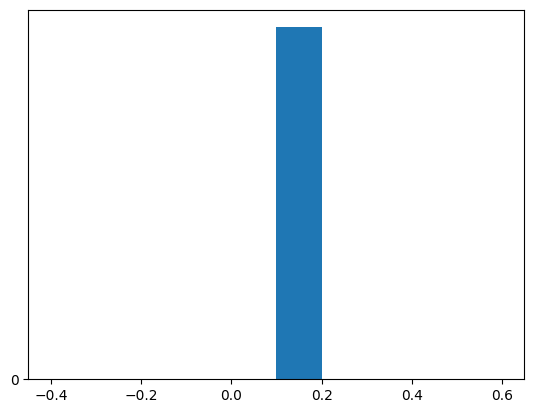

In [38]:
marked_data = calc_time_between_transitions(x_ts_half_pi)
plt.yticks(*get_rad_ticks(0, 1))
plt.hist(marked_data)

# White noise

## Graphs of the function and derivative

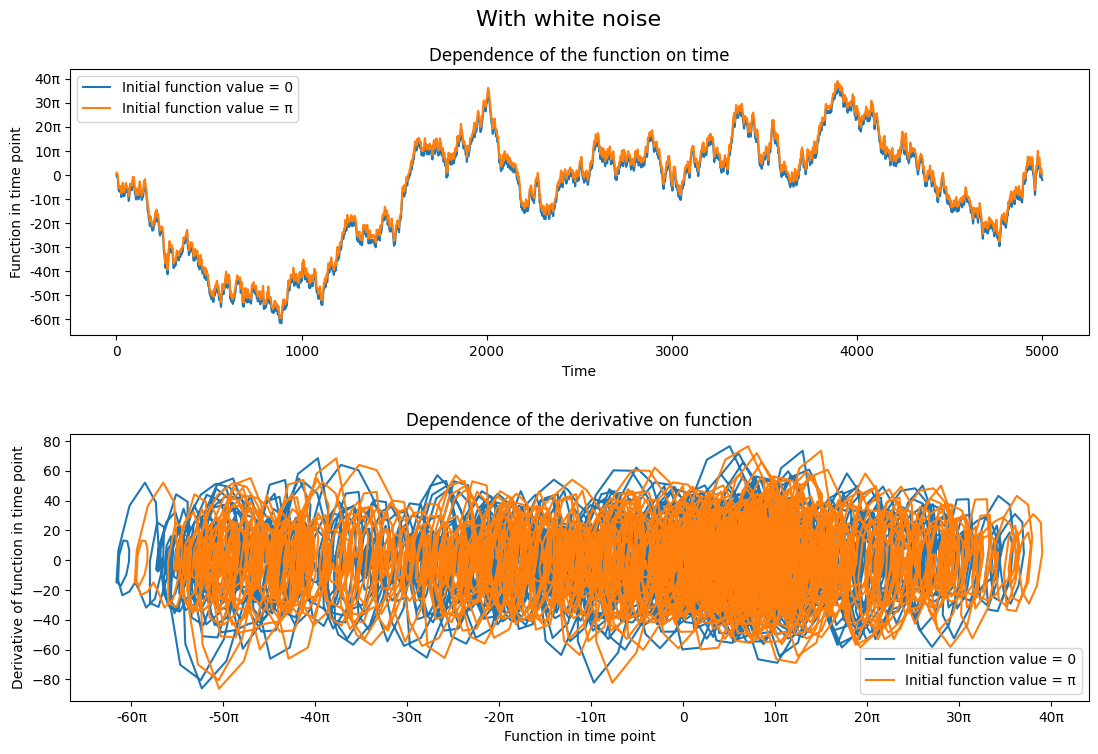

In [32]:
white_noise = generate_noise()
x_ts_0, d_ts_0 = get_samples(x_t_init = 0, noise=white_noise)
x_ts_pi, d_ts_pi = get_samples(x_t_init = math.pi, noise=white_noise)

ax1, ax2 = set_up_plot('With white noise', figsize=(12, 8), ticks_range=(-140, 120, 10))

ax1.plot(x_ts_0, label='Initial function value = 0')
ax1.plot(x_ts_pi, label='Initial function value = π')
ax1.legend()

ax2.plot(x_ts_0, d_ts_0, label='Initial function value = 0')
ax2.plot(x_ts_pi, d_ts_pi, label='Initial function value = π')
ax2.legend()

## Distribution of transition points on delta t

(array([2.027e+03, 2.710e+02, 1.580e+02, 7.700e+01, 3.700e+01, 1.300e+01,
        1.300e+01, 8.000e+00, 2.000e+00, 4.000e+00]),
 array([0.1 , 0.21, 0.32, 0.43, 0.54, 0.65, 0.76, 0.87, 0.98, 1.09, 1.2 ]),
 <BarContainer object of 10 artists>)

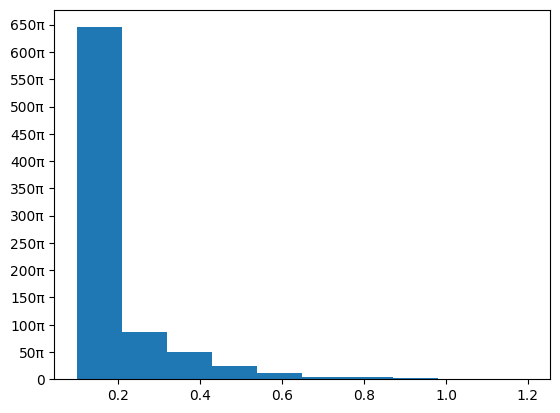

In [34]:
marked_data = calc_time_between_transitions(x_ts_0)
plt.yticks(*get_rad_ticks(0, 700, 50))
plt.hist(marked_data)

# Brown noise

## Graphs of the function and derivative

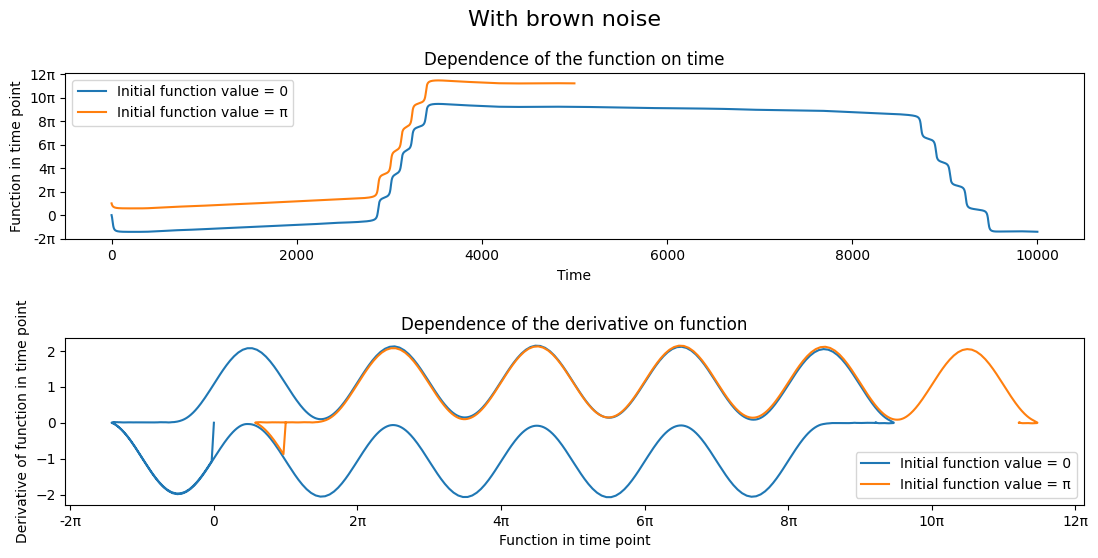

In [26]:
brown_noise = generate_noise(10_000, amplitude=lambda f: 1/f/f)
x_ts_0, d_ts_0 = get_samples(10_000, x_t_init = 0, noise=brown_noise)
x_ts_pi, d_ts_pi = get_samples(x_t_init = math.pi, noise=brown_noise)

ax1, ax2 = set_up_plot('With brown noise', figsize=(12, 6), ticks_range=(-10, 20, 2))

ax1.plot(x_ts_0, label='Initial function value = 0')
ax1.plot(x_ts_pi, label='Initial function value = π')
ax1.legend()

ax2.plot(x_ts_0, d_ts_0, label='Initial function value = 0')
ax2.plot(x_ts_pi, d_ts_pi, label='Initial function value = π')
ax2.legend()

(array([19.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([  1.1 ,  53.38, 105.66, 157.94, 210.22, 262.5 , 314.78, 367.06,
        419.34, 471.62, 523.9 ]),
 <BarContainer object of 10 artists>)

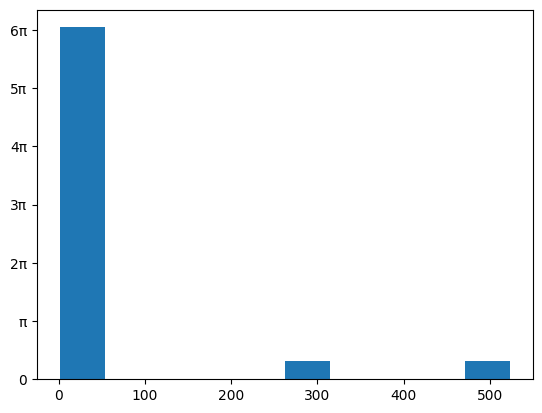

In [31]:
marked_data = calc_time_between_transitions(x_ts_0)
plt.yticks(*get_rad_ticks(0, 87))
plt.hist(marked_data)

## Distribution of transition points on delta t

# Blue noise

## Graphs of the function and derivative

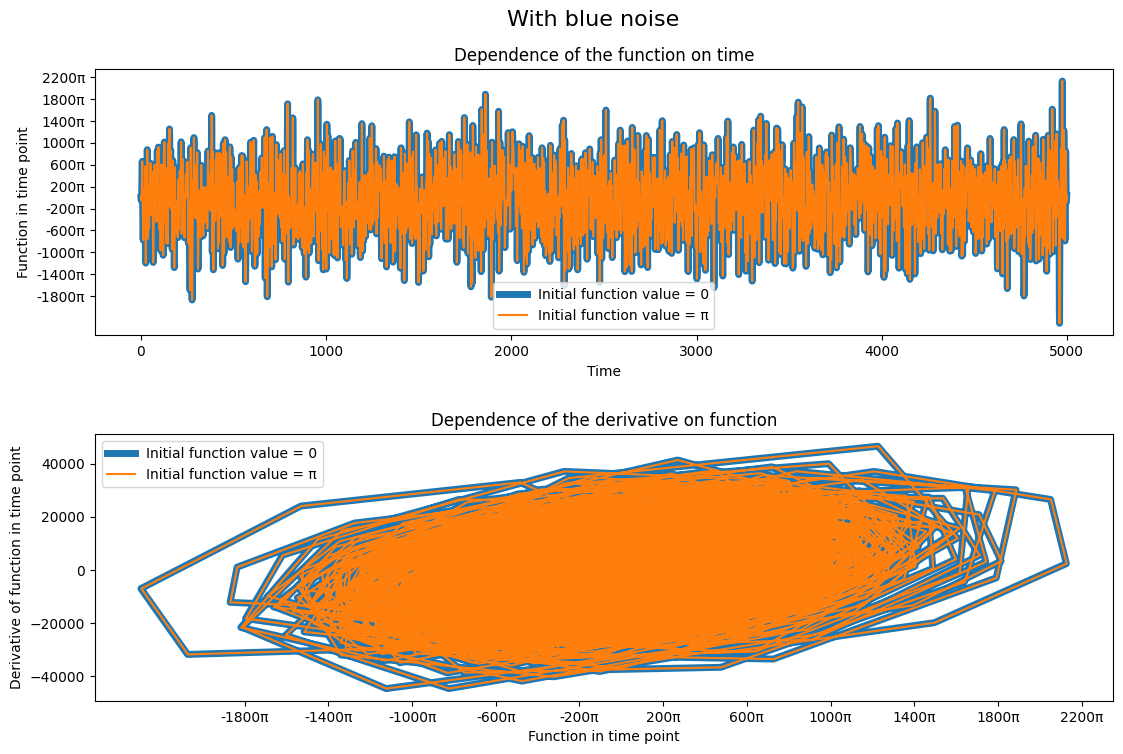

In [18]:
blue_noise = generate_noise(amplitude=lambda f: f)
x_ts_0, d_ts_0 = get_samples(x_t_init = 0, noise=blue_noise)
x_ts_pi, d_ts_pi = get_samples(x_t_init = math.pi, noise=blue_noise)

ax1, ax2 = set_up_plot('With blue noise', figsize=(12, 8), ticks_range=(-1800, 3000, 400))

ax1.plot(x_ts_0, label='Initial function value = 0', linewidth=5)
ax1.plot(x_ts_pi, label='Initial function value = π')
ax1.legend()

ax2.plot(x_ts_0, d_ts_0, label='Initial function value = 0', linewidth=5)
ax2.plot(x_ts_pi, d_ts_pi, label='Initial function value = π')
ax2.legend()

## Distribution of transition points on delta t

(array([4989.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           5.]),
 array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
 <BarContainer object of 10 artists>)

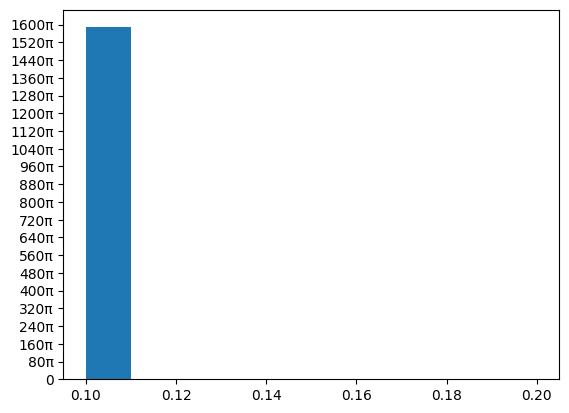

In [23]:
marked_data = calc_time_between_transitions(x_ts_0)
plt.yticks(*get_rad_ticks(0, 1800, 80))
plt.hist(marked_data)